In [1]:
from google.colab import drive
drive.mount('/content/gdrive',  force_remount = False)

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import cv2
import imageio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import  layers
from tensorflow.keras.models import Sequential
import pathlib

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
data_dir = r"/content/gdrive/MyDrive/data/seg_train"

In [5]:
batch_size=32
img_size=(180,180)
train_ds=tf.keras.utils.image_dataset_from_directory(
   data_dir,
   validation_split=0.2 ,
   subset='training',
   seed=123,
   image_size=img_size,
   batch_size=batch_size

)

Found 14044 files belonging to 6 classes.
Using 11236 files for training.


In [6]:
val_ds=tf.keras.utils.image_dataset_from_directory(
   data_dir,
   validation_split=0.2 ,
   subset='validation',
   seed=123,
   image_size=img_size,
   batch_size=batch_size

)

Found 14044 files belonging to 6 classes.
Using 2808 files for validation.


In [7]:
class_names=train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


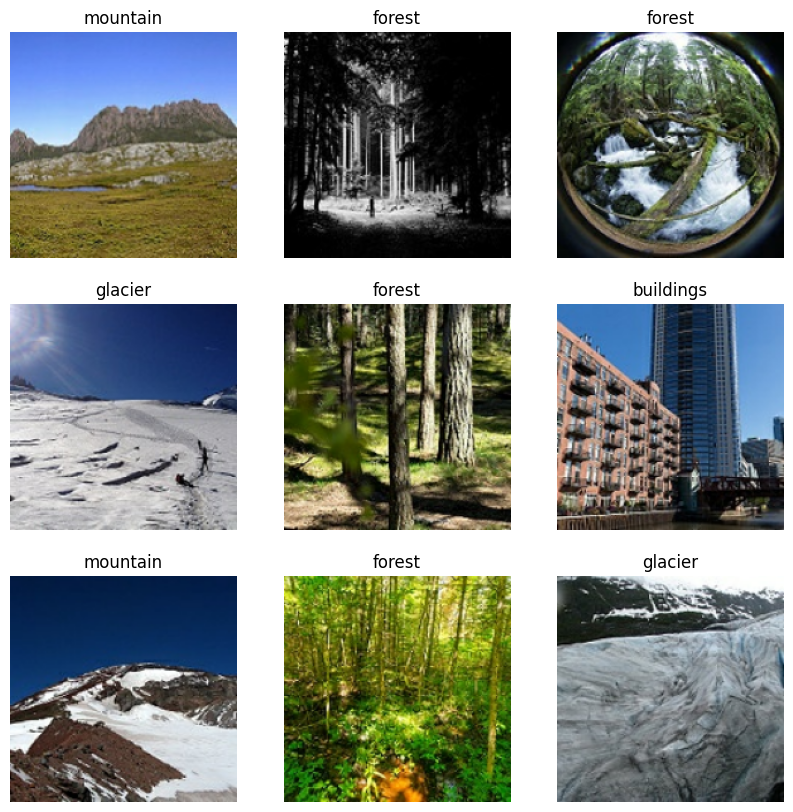

In [8]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(2):
  for i in range (9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [9]:
for image_batch ,labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer=layers.Rescaling(1.0/255)

In [12]:
normalized_ds=train_ds.map(lambda x,y :(normalization_layer(x),y))

In [13]:
# model building
num_classes=len(class_names)

model=Sequential([
                  layers.Rescaling((1.0/255),input_shape=(180,180,3)),
                  layers.Conv2D(16,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Flatten(),
                  layers.Dense(128,activation='relu'),
                  layers.Dense(num_classes)


])


In [14]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
history=model.fit(train_ds,validation_data=val_ds,
          epochs=10)

Epoch 1/10
352/352 [==============================] - 3073s 2s/step - loss: 0.9793 - accuracy: 0.6257 - val_loss: 0.7999 - val_accuracy: 0.6916
Epoch 2/10
352/352 [==============================] - 8s 22ms/step - loss: 0.6587 - accuracy: 0.7588 - val_loss: 0.5905 - val_accuracy: 0.7913
Epoch 3/10
352/352 [==============================] - 8s 23ms/step - loss: 0.4846 - accuracy: 0.8288 - val_loss: 0.5655 - val_accuracy: 0.7988
Epoch 4/10
352/352 [==============================] - 7s 21ms/step - loss: 0.3277 - accuracy: 0.8833 - val_loss: 0.7336 - val_accuracy: 0.7593
Epoch 5/10
352/352 [==============================] - 8s 23ms/step - loss: 0.1934 - accuracy: 0.9345 - val_loss: 0.6819 - val_accuracy: 0.8013
Epoch 6/10
352/352 [==============================] - 7s 21ms/step - loss: 0.1163 - accuracy: 0.9635 - val_loss: 0.7867 - val_accuracy: 0.7999
Epoch 7/10
352/352 [==============================] - 8s 22ms/step - loss: 0.0761 - accuracy: 0.9764 - val_loss: 0.9340 - val_accuracy: 0.783

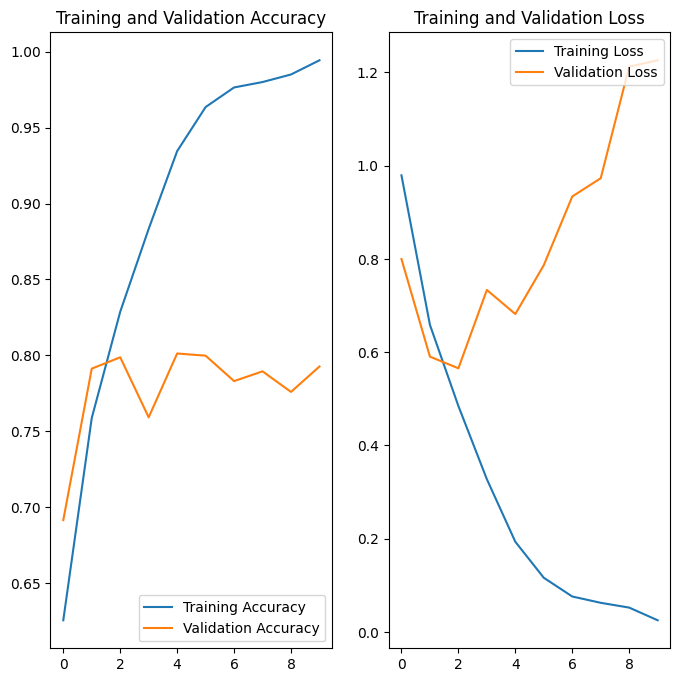

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal',input_shape=(180,180,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)]
)

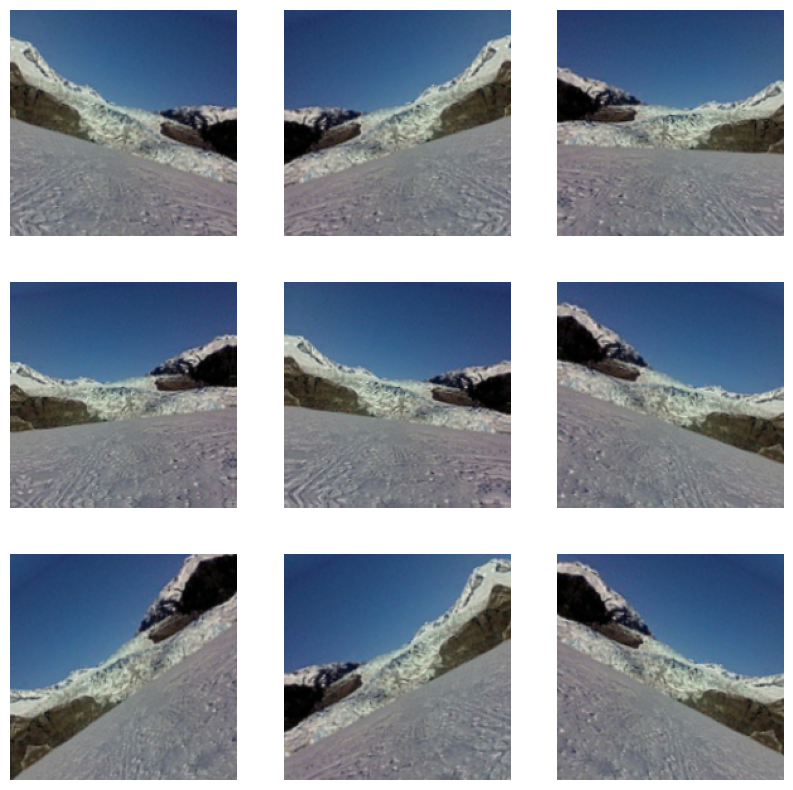

In [21]:
plt.figure(figsize=(10,10))

for images, _ in train_ds.take(1):
  for i in range (9):
    augmented_images=data_augmentation(images)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))

    plt.axis('off')

In [39]:
model=Sequential([
                  data_augmentation,
                  layers.Rescaling((1.0/255),input_shape=(180,180,3)),
                  layers.Conv2D(16,3,padding='same',activation='relu'),
                  layers.Dropout(0.2),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32,3,padding='same',activation='relu'),
                  layers.Dropout(0.2),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Flatten(),
                  layers.Dense(128,activation='relu'),
                  layers.Dropout(0.2),
                  layers.Dense(num_classes),
                  layers.Dense(10,activation='softmax')




])

In [41]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
history=model.fit(train_ds,validation_data=val_ds,
          epochs=15)

Epoch 1/15
352/352 [==============================] - 16s 35ms/step - loss: 0.5664 - accuracy: 0.7969 - val_loss: 0.5435 - val_accuracy: 0.8077
Epoch 2/15
352/352 [==============================] - 12s 35ms/step - loss: 0.5445 - accuracy: 0.8064 - val_loss: 0.4979 - val_accuracy: 0.8234
Epoch 3/15
352/352 [==============================] - 12s 34ms/step - loss: 0.5200 - accuracy: 0.8130 - val_loss: 0.5382 - val_accuracy: 0.8162
Epoch 4/15
352/352 [==============================] - 12s 34ms/step - loss: 0.5084 - accuracy: 0.8209 - val_loss: 0.5381 - val_accuracy: 0.8002
Epoch 5/15
352/352 [==============================] - 12s 35ms/step - loss: 0.5055 - accuracy: 0.8208 - val_loss: 0.4987 - val_accuracy: 0.8202
Epoch 6/15
352/352 [==============================] - 12s 34ms/step - loss: 0.5008 - accuracy: 0.8209 - val_loss: 0.4929 - val_accuracy: 0.8266
Epoch 7/15
352/352 [==============================] - 12s 34ms/step - loss: 0.4775 - accuracy: 0.8252 - val_loss: 0.5037 - val_accuracy:

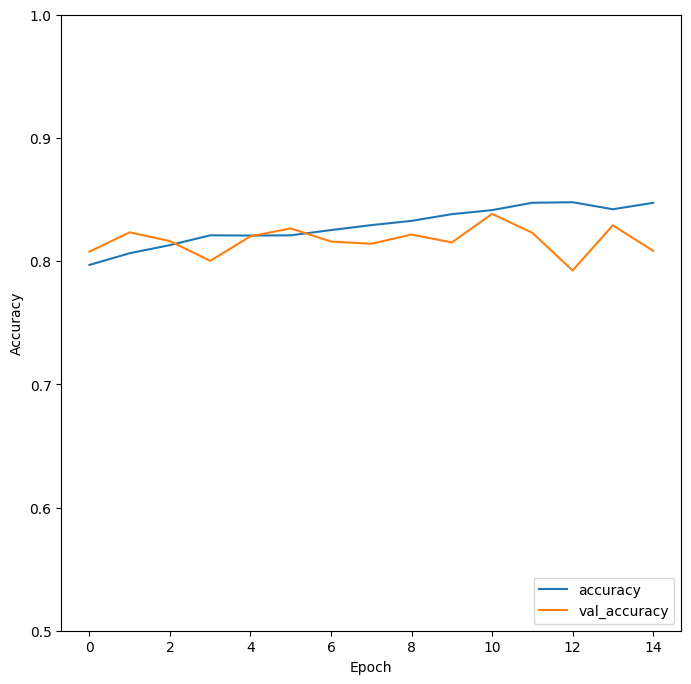

In [42]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.savefig("output_report.png")

In [45]:
model.save('savedflowermodel')

In [46]:
# ! zip /content/savedflowermodel.zip  /content/savedflowermodel
!zip -r /content/savedflowermodel.zip /content/savedflowermodel

  adding: content/savedflowermodel/ (stored 0%)
  adding: content/savedflowermodel/fingerprint.pb (stored 0%)
  adding: content/savedflowermodel/keras_metadata.pb (deflated 93%)
  adding: content/savedflowermodel/saved_model.pb (deflated 89%)
  adding: content/savedflowermodel/assets/ (stored 0%)
  adding: content/savedflowermodel/variables/ (stored 0%)
  adding: content/savedflowermodel/variables/variables.index (deflated 65%)
  adding: content/savedflowermodel/variables/variables.data-00000-of-00001 (deflated 46%)
